# Exploring key predictors of CS enrollment in Washington state

We will be using the data table at https://github.com/lgtanimoto/WAStateCSEd/blob/main/2022/2022_school_pt.csv created from the 2021-22 CSEd Summary Report published by OSPI which shows for each high school, how many students, how many student enrollments, how many male students, how many male student enrollments, how many female students, how many female student enrollments, how many gender X, how many gender X enrollments, and does similar info for race/ethnicity, FRL status, ELL status, disability status.   Cross-sectional data (e.g. how many black female enrollments) is not available. With this data we will generate 300,000 random student records and then perform PCA analysis to discover key predictors of CS enrollment in Washington state.

## Summary
* **Initial Exploration**
* **Generating Synthetic Student Data**
 * **Three Methodologies for CS Enrollment Column**
 * **Calculating probabilities based on all data**
 * **Calculating probabilities based on data per school**
* **Analysis of Synthetic Student Data**
 * **Analysis of synthetic students based on all data**
   * Logistic Regression
   * Random Forest
   * Mutual Information
   * PCA 
 * **Analysis of synthetic students based on data per school**
   * Logistic Regression
   * Random Forest
   * Mutual Information
   * PCA


## Initial Exploration

First, we need to import the libraries we will need to explore and analyze this data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import datasets
from sklearn.tree import export_graphviz
from io import StringIO  
from IPython.display import Image  
import pydotplus
import warnings
warnings.filterwarnings('ignore')

Then we will upload the data that we will be using to generate random student records.

In [2]:
ospi_data = pd.read_csv('2022_school_pt.csv',  index_col=0)

Let's take a look at the first few records from the csv file to better understand the school records we are working with.

In [3]:
ospi_data.head()

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,...,D_NoDisability,DC_NoDisability,A_9,AC_9,A_10,AC_10,A_11,AC_11,A_12,AC_12
0,1109,3075,28,3,9,0,19,3,0,0,...,26,3,7,0,4,0,6,1,11,2
1,1147,3015,1281,169,635,60,646,109,0,0,...,1086,140,382,51,328,44,321,29,250,45
2,1158,2903,60,22,30,12,29,10,1,0,...,57,21,18,12,15,2,14,2,13,6
3,1160,2132,113,24,57,13,56,11,0,0,...,107,20,32,7,35,5,25,4,21,8
4,2250,1617,167,0,89,0,78,0,0,0,...,142,0,16,0,51,0,41,0,59,0


In [4]:
len(ospi_data.index)

730

Next we need to make sure the data is clean and suitable for manipulation by searching for missing values. We will handle normalization later, in different ways, depending on the method for synthetic data generation.

In [5]:
num_missing_val = ospi_data.isnull().sum()
num_missing_val.sum()

0

We see that there are no missing values so now we will move on to generating 300,000 random student records with the help of numpy.

To do this, we need to gather the probabilities implied by the given dataset. These probabilities need to be calculated from each of the columns--comparing the total number of students belonging to each feature category to the number that enrolled in a CS course. We also need to find probabilities for which category a single student will belong to.

In [6]:
ospi_data.columns

Index(['DistrictCode', 'SchoolCode', 'AllStudents', 'C_AllStudents',
       'G_Female', 'GC_Female', 'G_Male', 'GC_Male', 'G_GenderX', 'GC_GenderX',
       'R_Native', 'RC_Native', 'R_Asian', 'RC_Asian', 'R_Black', 'RC_Black',
       'R_Hisp_Lat', 'RC_Hisp_Lat', 'R_HPI', 'RC_HPI', 'R_NA', 'RC_NA',
       'R_TwoOrMore', 'RC_TwoOrMore', 'R_White', 'RC_White', 'L_ELL', 'LC_ELL',
       'L_NoELL', 'LC_NoELL', 'I_LowIncome', 'IC_LowIncome', 'I_NoLowIncome',
       'IC_NOLowIncome', 'D_Disability', 'DC_Disability', 'D_NoDisability',
       'DC_NoDisability', 'A_9', 'AC_9', 'A_10', 'AC_10', 'A_11', 'AC_11',
       'A_12', 'AC_12'],
      dtype='object')

An interesting consideration to begin with is looking at the ratio of all students who enroll in CS:

In [7]:
sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents)

0.07654341235652434

This shows that about 7.65% of all students in this dataset enrolled in CS. 

## Synthetic Student Generation 

### Without Consideration for School

Now, let's go through each of the columns to assign probabilities to every category of student.

In [8]:
Prob_GC_Female = sum(ospi_data.GC_Female) / sum(ospi_data.G_Female)
Prob_GC_Male = sum(ospi_data.GC_Male) / sum(ospi_data.G_Male)
Prob_GC_GenderX = sum(ospi_data.GC_GenderX) / sum(ospi_data.G_GenderX)
Prob_RC_Native = sum(ospi_data.RC_Native) / sum(ospi_data.R_Native)
Prob_RC_Asian = sum(ospi_data.RC_Asian) / sum(ospi_data.R_Asian)
Prob_RC_Black = sum(ospi_data.RC_Black) / sum(ospi_data.R_Black)
Prob_RC_Hisp_Lat = sum(ospi_data.RC_Hisp_Lat) / sum(ospi_data.R_Hisp_Lat)
Prob_RC_HPI = sum(ospi_data.RC_HPI) / sum(ospi_data.R_HPI)
Prob_RC_NA = sum(ospi_data.RC_NA) / sum(ospi_data.R_NA)
Prob_RC_TwoOrMore = sum(ospi_data.RC_TwoOrMore) / sum(ospi_data.R_TwoOrMore)
Prob_RC_White = sum(ospi_data.RC_White) / sum(ospi_data.R_White)
Prob_LC_ELL = sum(ospi_data.LC_ELL) / sum(ospi_data.L_ELL)
Prob_LC_NoELL = sum(ospi_data.LC_NoELL) / sum(ospi_data.L_NoELL)
Prob_IC_LowIncome = sum(ospi_data.IC_LowIncome) / sum(ospi_data.I_LowIncome)
Prob_IC_NoLowIncome = sum(ospi_data.IC_NOLowIncome) / sum(ospi_data.I_NoLowIncome)
Prob_DC_Disability = sum(ospi_data.DC_Disability) / sum(ospi_data.D_Disability)
Prob_DC_NoDisability = sum(ospi_data.DC_NoDisability) / sum(ospi_data.D_NoDisability)
Prob_AC_9 = sum(ospi_data.AC_9) / sum(ospi_data.A_9)
Prob_AC_10 = sum(ospi_data.AC_10) / sum(ospi_data.A_10)
Prob_AC_11 = sum(ospi_data.AC_11) / sum(ospi_data.A_11)
Prob_AC_12 = sum(ospi_data.AC_12) / sum(ospi_data.A_12)

There's more work to do but let's pause and notice that we can now easily compare probabilities, like for gender:

In [9]:
print(Prob_GC_Female)
print(Prob_GC_Male)
print(Prob_GC_GenderX)

0.04510418114369407
0.10592888529774107
0.07277526395173455


These numbers suggest that there's more than double the probability that a male student will enroll in a CS course versus a female student. Also interesting to note is that a student identifying as GenderX has a higher probability of enrolling than a female student. However, this probability may not be completely realistic because there are far fewer students who identify as GenderX, compared to male or female.

In [10]:
print(sum(ospi_data.G_Female))
print(sum(ospi_data.G_Male))
print(sum(ospi_data.G_GenderX))

187078
200493
2652


Next we will find probabilities for which category a student will belong to.

In [11]:
Prob_G_Female = sum(ospi_data.G_Female) / sum(ospi_data.AllStudents)
Prob_G_Male = sum(ospi_data.G_Male) / sum(ospi_data.AllStudents)
Prob_G_GenderX = sum(ospi_data.G_GenderX) / sum(ospi_data.AllStudents)
Prob_R_Native = sum(ospi_data.R_Native) / sum(ospi_data.AllStudents)
Prob_R_Asian = sum(ospi_data.R_Asian) / sum(ospi_data.AllStudents)
Prob_R_Black = sum(ospi_data.R_Black) / sum(ospi_data.AllStudents)
Prob_R_Hisp_Lat = sum(ospi_data.R_Hisp_Lat) / sum(ospi_data.AllStudents)
Prob_R_HPI = sum(ospi_data.R_HPI) / sum(ospi_data.AllStudents)
Prob_R_NA = sum(ospi_data.R_NA) / sum(ospi_data.AllStudents)
Prob_R_TwoOrMore = sum(ospi_data.R_TwoOrMore) / sum(ospi_data.AllStudents)
Prob_R_White = sum(ospi_data.R_White) / sum(ospi_data.AllStudents)
Prob_L_ELL = sum(ospi_data.L_ELL) / sum(ospi_data.AllStudents)
Prob_I_LowIncome = sum(ospi_data.I_LowIncome) / sum(ospi_data.AllStudents)
Prob_I_NoLowIncome = sum(ospi_data.I_NoLowIncome) / sum(ospi_data.AllStudents)
Prob_D_Disability = sum(ospi_data.D_Disability) / sum(ospi_data.AllStudents)
Prob_D_NoDisability = sum(ospi_data.D_NoDisability) / sum(ospi_data.AllStudents)
Prob_A_9 = sum(ospi_data.A_9) / sum(ospi_data.AllStudents)
Prob_A_10 = sum(ospi_data.A_10) / sum(ospi_data.AllStudents)
Prob_A_11 = sum(ospi_data.A_11) / sum(ospi_data.AllStudents)
Prob_A_12 = sum(ospi_data.A_12) / sum(ospi_data.AllStudents)

Now, we can use these probabilities to begin creating a synthetic dataset of student records. Let's start with gender.

In [12]:
rng = np.random.default_rng(seed=6525)

# How many student records we want to generate

num_students = 400000

# Load and normalize probabilities
# Gender

g_probs = np.array([Prob_G_Female, Prob_G_Male, Prob_G_GenderX])
g_probs /= np.sum(g_probs)

# Race

r_probs = np.array([Prob_R_Native, Prob_R_Asian, Prob_R_Black, Prob_R_Hisp_Lat, Prob_R_HPI, Prob_R_NA, Prob_R_TwoOrMore, Prob_R_White])
r_probs /= np.sum(r_probs)

# ELL

e_probs = np.array([1-Prob_L_ELL, Prob_L_ELL])

# Income

i_probs = np.array([Prob_I_NoLowIncome, Prob_I_LowIncome])

# Disability

d_probs = np.array([Prob_D_NoDisability, Prob_D_Disability])

# Grade

a_probs = np.array([Prob_A_9, Prob_A_10, Prob_A_11, Prob_A_12])
a_probs /= np.sum(a_probs)

# Generate values for categorical attributes

rng = np.random.default_rng(seed=6525)
gender = rng.choice(['female', 'male', 'x'], size = num_students, p = g_probs)
race = rng.choice(['Native', 'Asian', 'Black', 'Hisp_Lat', 'HPI', 'NA', 'TwoOrMore', 'White'], size = num_students, p = r_probs)
ell = rng.choice([0, 1], size = num_students, p = e_probs)
income = rng.choice([0, 1], size = num_students, p = i_probs)
disability = rng.choice([0, 1], size = num_students, p = d_probs)
grade = rng.choice(['9', '10', '11', '12'], size = num_students, p = a_probs)

# Print the first few synthetic data points to ensure that this is working as expected
print(gender[:10])
print(race[:10])
print(ell[:10])
print(income[:10])
print(disability[:10])
print(grade[:10])

['female' 'male' 'female' 'male' 'female' 'male' 'male' 'female' 'female'
 'male']
['Hisp_Lat' 'White' 'White' 'White' 'White' 'Hisp_Lat' 'Hisp_Lat'
 'Hisp_Lat' 'Asian' 'White']
[0 0 0 0 0 0 1 0 0 0]
[0 0 1 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0]
['9' '9' '10' '10' '9' '11' '10' '12' '12' '10']


Let's create a dataframe to hold these new records and add what we've generated as columns.

In [13]:
synth_students = pd.DataFrame()
synth_students.insert(0, "Gender", gender, True)
synth_students.insert(1, "Race", race, True)
synth_students.insert(2, "ELL", ell, True)
synth_students.insert(3, "Low Income", income, True)
synth_students.insert(4, "Disability", disability, True)
synth_students.insert(5, "Grade", grade, True)

After that we can take a look at some of our student records.

In [14]:
synth_students.head()

,Gender,Race,ELL,Low Income,Disability,Grade
0,female,Hisp_Lat,0,0,0,9
1,male,White,0,0,0,9
2,female,White,0,1,0,10
3,male,White,0,0,0,10
4,female,White,0,0,0,9


### CS Enrollment Generation

One thing is missing from this synthetic data--whether or not each synthesized student is enrolled in CS. Creating this column will be a little more complex than the previous because we need to use the probabilities of the column values of each row to calculate whether or not the synthesized student is enrolled in CS.

In order to do this, let's convert all of those synthesized student column values into probabilities that they will be enrolled in CS. E.g. if a column value is "Hisp_Lat" then replace it with the variable Prob_RC_Hisp_Lat that we created earlier.

In [15]:
synth_students.replace("Hisp_Lat", Prob_RC_Hisp_Lat)

,Gender,Race,ELL,Low Income,Disability,Grade
0,female,0.066245,0,0,0,9
1,male,White,0,0,0,9
2,female,White,0,1,0,10
3,male,White,0,0,0,10
4,female,White,0,0,0,9
...,...,...,...,...,...,...
399995,male,White,0,0,1,9
399996,female,0.066245,0,1,0,10
399997,male,White,0,0,0,11
399998,female,White,0,1,0,9


Now, we'll do this for each variable.

In [16]:
synth_students.replace("Hisp_Lat", Prob_RC_Hisp_Lat)

,Gender,Race,ELL,Low Income,Disability,Grade
0,female,0.066245,0,0,0,9
1,male,White,0,0,0,9
2,female,White,0,1,0,10
3,male,White,0,0,0,10
4,female,White,0,0,0,9
...,...,...,...,...,...,...
399995,male,White,0,0,1,9
399996,female,0.066245,0,1,0,10
399997,male,White,0,0,0,11
399998,female,White,0,1,0,9


But it's not best practice to manipulate the dataframe we have. Instead we should create a new dataframe. There are a few ways to do this. Today we will create a new dataframe out of each column, replace(1) values with the associated probabilities, and then bring them back together in a dataframe so that we can calculate our final column of whether or not the student is enrolled in CS.

1: We are using the attribute "inplace=True" to actually manipulate the new dataframes we create out of the columns. In the previous example we did not use this attribute so the dataframe was not actually changed. 

In [17]:
ell_df = synth_students[['ELL']].copy()

In [18]:
ell_df.replace(1, Prob_LC_ELL, inplace=True)

In [19]:
zero_prob = Prob_LC_NoELL
ell_df.replace(0, zero_prob, inplace=True)

In [20]:
gend_df = synth_students[['Gender']].copy()
race_df = synth_students[['Race']].copy()
inc_df = synth_students[['Low Income']].copy()
dis_df = synth_students[['Disability']].copy()
gr_df = synth_students[['Grade']].copy()

In [21]:
gend_df.replace('male', Prob_GC_Male, inplace=True)
gend_df.replace('female', Prob_GC_Female, inplace=True)
gend_df.replace('x', Prob_GC_GenderX, inplace=True)

In [22]:
race_df.replace('Native', Prob_RC_Native, inplace=True)
race_df.replace('Asian', Prob_RC_Asian, inplace=True)
race_df.replace('Black', Prob_RC_Black, inplace=True)
race_df.replace('Hisp_Lat', Prob_RC_Hisp_Lat, inplace=True)
race_df.replace('HPI', Prob_RC_HPI, inplace=True)
race_df.replace('NA', Prob_RC_NA, inplace=True)
race_df.replace('TwoOrMore', Prob_RC_TwoOrMore, inplace=True)
race_df.replace('White', Prob_RC_White, inplace=True)

In [23]:
inc_df.replace(0, Prob_IC_NoLowIncome, inplace=True)
inc_df.replace(1, Prob_IC_LowIncome, inplace=True)

In [24]:
dis_df.replace(0, Prob_DC_NoDisability, inplace=True)
dis_df.replace(1, Prob_DC_Disability, inplace=True)

In [25]:
gr_df.replace('9', Prob_AC_9, inplace=True)
gr_df.replace('10', Prob_AC_10, inplace=True)
gr_df.replace('11', Prob_AC_11, inplace=True)
gr_df.replace('12', Prob_AC_12, inplace=True)

After all of the columns have had their values replaced with probabilities we need to bring them all together in a single dataframe to calculate the probability of enrollment in CS based on those proabibilities. 

In [26]:
calc_prob = pd.DataFrame()
calc_prob["Gender"] = gend_df
calc_prob["Race"] = race_df
calc_prob["ELL"] = ell_df
calc_prob["Income"] = inc_df
calc_prob["Disability"] = dis_df
calc_prob["Grade"] = gr_df
calc_prob.head()

,Gender,Race,ELL,Income,Disability,Grade
0,0.045104,0.066245,0.078064,0.083896,0.079513,0.103522
1,0.105929,0.072356,0.078064,0.083896,0.079513,0.103522
2,0.045104,0.072356,0.078064,0.067853,0.079513,0.079958
3,0.105929,0.072356,0.078064,0.083896,0.079513,0.079958
4,0.045104,0.072356,0.078064,0.083896,0.079513,0.103522


### Three Methodologies for CS Enrollment Column

To do this we will need a function to calculate the probability of CS enrollment for each row but are missing important information for conditional probabilities--we know the probability of whether or not somebody enrolls in CS because of one feature, but not multiple features. No cross-sectional or intersectional data is available. So instead we will calculate CS enrollment three ways and decide which is best for our use case. 

In [27]:
def calc_m1_prob(row):
    return min(row['Gender'], row['Race'], row['ELL'], row['Income'], row['Disability'], row['Grade'])


calc_prob['M1_Prob'] = calc_prob.apply(calc_m1_prob, axis=1)


def is_cs_m1(prob):
    np.random.seed(12345)
    return np.random.choice([0, 1], p=[1 - prob, prob])

calc_prob['CS_M1'] = calc_prob['M1_Prob'].apply(is_cs_m1)

Another possible method would be to use the probability found from all students, not taking features into account.

In [28]:
Prob_All = sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents)
a_probs = np.array([1-Prob_All, Prob_All])
CS_M2 = rng.choice([0, 1], size = num_students, p = a_probs)
calc_prob.insert(8, "CS_M2", CS_M2, True)

A third method would be to average the probabilities taken from the synthesized student's features. This is meant to represent intersectionality--intersecting social identities and how that affects outcomes.

In [29]:
def calc_m3_prob(row):
    return (row['Gender'] + row['Race'] + row['ELL'] + row['Income'] + row['Disability'] + row['Grade']) / 6


calc_prob['M3_Prob'] = calc_prob.apply(calc_m3_prob, axis=1)


def is_cs_m3(prob):
    return np.random.choice([0, 1], p=[1 - prob, prob])

calc_prob['CS_M3'] = calc_prob['M3_Prob'].apply(is_cs_m3)
calc_prob.head()

,Gender,Race,ELL,Income,Disability,Grade,M1_Prob,CS_M1,CS_M2,M3_Prob,CS_M3
0,0.045104,0.066245,0.078064,0.083896,0.079513,0.103522,0.045104,0,0,0.076057,0
1,0.105929,0.072356,0.078064,0.083896,0.079513,0.103522,0.072356,1,0,0.087213,0
2,0.045104,0.072356,0.078064,0.067853,0.079513,0.079958,0.045104,0,0,0.070475,0
3,0.105929,0.072356,0.078064,0.083896,0.079513,0.079958,0.072356,1,1,0.083286,0
4,0.045104,0.072356,0.078064,0.083896,0.079513,0.103522,0.045104,0,0,0.077076,0


Let's compare the different percentages of CS enrollment between methods and the sample data.

In [30]:
pct_All_CS_synth1 = f"{sum(calc_prob['CS_M1']) / num_students:%}"
pct_All_CS_synth2 = f"{sum(calc_prob['CS_M2']) / num_students:%}"
pct_All_CS_synth3 = f"{sum(calc_prob['CS_M3']) / num_students:%}"
pct_All_CS_ospi = f"{sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents):%}"
print("Method 1:", pct_All_CS_synth1)
print("Method 2:",pct_All_CS_synth2)
print("Method 3:",pct_All_CS_synth3)
print("OSPI Data:",pct_All_CS_ospi)

Method 1: 7.298250%
Method 2: 7.667000%
Method 3: 7.709500%
OSPI Data: 7.654341%


Method 2 and Method 3 appear to yield the closest results. However recall that only Method 3 takes into consideration the demographics of the student while Method 2 just uses the overall probability that anybody would be enrolled in CS.

How can we find key predictors when CS enrollment is not based on any demographic information? We will conduct analysis using both methods and compare to see if the relationship between demographics and CS enrollment used in Method 3 increases value in our analysis.

In [31]:
all_synth = pd.concat([synth_students, calc_prob], axis=1)
all_synth.head(5)

,Gender,Race,ELL,Low Income,Disability,Grade,Gender,Race,ELL,Income,Disability,Grade,M1_Prob,CS_M1,CS_M2,M3_Prob,CS_M3
0,female,Hisp_Lat,0,0,0,9,0.045104,0.066245,0.078064,0.083896,0.079513,0.103522,0.045104,0,0,0.076057,0
1,male,White,0,0,0,9,0.105929,0.072356,0.078064,0.083896,0.079513,0.103522,0.072356,1,0,0.087213,0
2,female,White,0,1,0,10,0.045104,0.072356,0.078064,0.067853,0.079513,0.079958,0.045104,0,0,0.070475,0
3,male,White,0,0,0,10,0.105929,0.072356,0.078064,0.083896,0.079513,0.079958,0.072356,1,1,0.083286,0
4,female,White,0,0,0,9,0.045104,0.072356,0.078064,0.083896,0.079513,0.103522,0.045104,0,0,0.077076,0


### One Hot Encoding Gender and Race

After we've created this last column, we can create our final dataset that will be ready for analysis. One way to prepare this dataset is making all columns binary, also known as "one hot encoding."

In [32]:
binary_gender = pd.get_dummies(synth_students['Gender'])

In [33]:
binary_race = pd.get_dummies(synth_students['Race'])

In [34]:
binary_grade = pd.get_dummies(synth_students['Grade'])

Then concatenate these new columns with the existing synth_students dataframe and drop the non-binary ones.

In [35]:
binary_synth = pd.concat([synth_students, binary_gender, binary_race, binary_grade, calc_prob['CS_M1'], calc_prob['CS_M2'], calc_prob['CS_M3']], axis=1)
binary_synth = binary_synth.drop('Gender', axis=1)
binary_synth = binary_synth.drop('Race', axis=1)
binary_synth = binary_synth.drop('Grade', axis=1)

binary_synth.head(10)

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,...,Native,TwoOrMore,White,10,11,12,9,CS_M1,CS_M2,CS_M3
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
6,1,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
8,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0


### With Consideration to School

The methodology for generating by school:

1. Create probabilities by school for each row in the original opsi_data 
2. Then duplicate the row based on how many students are in the school (so for a school with 28 students, the row is repeated 28 times) 
3. Then from there, in each row, perform the random choosing of demographics for each student using the probabilities calculated by school 
4. Then use both Method 2 and Method 3 for filling in the CS enrollment column

#### Feature Engineering

We will approach two of our features differently in this round of synthesizing. We are modifying the use of these column either because the trends are explainable (CS enrollment goes down per grade level) or we do not have enough data on the characteristic to draw meaningful conclusions (Gender_X). 

For grade level, we will simply drop the rows. Later we will handle Gender_X by creating a single gender column, "Male" that will be encoded as 1 for "Male" or 0 for students who are not Male. This is because from initial analysis "Male" repeatedly appears to be a strong feature. **INSERT DISCLAIMER ABOUT OTHERING/BE SENSITIVE TO GENDER** 

In [36]:
synth_school = ospi_data.copy()
synth_school = synth_school.drop(['A_9', 'A_10', 'A_11', 'A_12', 'AC_9',
       'AC_10', 'AC_11', 'AC_12'], axis=1)
synth_probs = pd.DataFrame()

Next, we need to create a function that will do what we've done above for each row in our original dataframe from our sample data. This means that instead of creating one static probability for each demographic there will be different probabilities for each school.

In [37]:
# Calculating probabilities for each school

# Male

def calc_male_prob(row):
    return row['G_Male'] / row['AllStudents']

synth_school['G_Male_Prob'] = synth_school.apply(calc_male_prob, axis=1)

# Native

def calc_native_prob(row):
    return row['R_Native'] / row['AllStudents']

synth_school['R_Native_Prob'] = synth_school.apply(calc_native_prob, axis=1)

# Asian

def calc_asian_prob(row):
    return row['R_Asian'] / row['AllStudents']

synth_school['R_Asian_Prob'] = synth_school.apply(calc_asian_prob, axis=1)

# Black

def calc_black_prob(row):
    return row['R_Black'] / row['AllStudents']

synth_school['R_Black_Prob'] = synth_school.apply(calc_black_prob, axis=1)

# Hisp_Lat

def calc_hisp_lat_prob(row):
    return row['R_Hisp_Lat'] / row['AllStudents']

synth_school['R_Hisp_Lat_Prob'] = synth_school.apply(calc_hisp_lat_prob, axis=1)

# HPI

def calc_hpi_prob(row):
    return row['R_HPI'] / row['AllStudents']

synth_school['R_HPI_Prob'] = synth_school.apply(calc_hpi_prob, axis=1)

# R_NA

def calc_na_prob(row):
    return row['R_NA'] / row['AllStudents']

synth_school['R_NA_Prob'] = synth_school.apply(calc_na_prob, axis=1)

# R_TwoOrMore

def calc_twoormore_prob(row):
    return row['R_TwoOrMore'] / row['AllStudents']

synth_school['R_TwoOrMore_Prob'] = synth_school.apply(calc_twoormore_prob, axis=1)

# White

def calc_white_prob(row):
    return row['R_White'] / row['AllStudents']

synth_school['R_White_Prob'] = synth_school.apply(calc_white_prob, axis=1)

# ELL

def calc_ell_prob(row):
    return row['L_ELL'] / row['AllStudents']

synth_school['L_ELL_Prob'] = synth_school.apply(calc_ell_prob, axis=1)

# No ELL

def calc_noell_prob(row):
    return row['L_NoELL'] / row['AllStudents']

synth_school['L_NoELL_Prob'] = synth_school.apply(calc_noell_prob, axis=1)

# Low Income

def calc_lowincome_prob(row):
    return row['I_LowIncome'] / row['AllStudents']

synth_school['I_LowIncome_Prob'] = synth_school.apply(calc_lowincome_prob, axis=1)

# No Low Income

def calc_nolow_prob(row):
    return row['I_NoLowIncome'] / row['AllStudents']

synth_school['I_NoLowIncome_Prob'] = synth_school.apply(calc_nolow_prob, axis=1)

# Disability

def calc_disability_prob(row):
    return row['D_Disability'] / row['AllStudents']

synth_school['D_Disability_Prob'] = synth_school.apply(calc_disability_prob, axis=1)

# No Disability

def calc_nodisability_prob(row):
    return row['D_NoDisability'] / row['AllStudents']

synth_school['D_NoDisability_Prob'] = synth_school.apply(calc_nodisability_prob, axis=1)

In [38]:
# Calculating CS probabilities for each school

# Gender X (we will combine this probability with Female to get the probability of "Not Male")

def calc_x_cs_prob(row):
    return row['GC_GenderX'] / row['G_GenderX']

synth_school['GC_GenderX_Prob'] = synth_school.apply(calc_x_cs_prob, axis=1)

# Female

def calc_fem_cs_prob(row):
    return row['GC_Female'] / row['G_Female']

synth_school['GC_Female_Prob'] = synth_school.apply(calc_fem_cs_prob, axis=1)

# Male

def calc_male_cs_prob(row):
    return row['GC_Male'] / row['G_Male']

synth_school['GC_Male_Prob'] = synth_school.apply(calc_male_cs_prob, axis=1)

# Native

def calc_native_cs_prob(row):
    return row['RC_Native'] / row['R_Native']

synth_school['RC_Native_Prob'] = synth_school.apply(calc_native_cs_prob, axis=1)

# Asian

def calc_asian_cs_prob(row):
    return row['RC_Asian'] / row['R_Asian']

synth_school['RC_Asian_Prob'] = synth_school.apply(calc_asian_cs_prob, axis=1)

# Black

def calc_black_cs_prob(row):
    return row['RC_Black'] / row['R_Black']

synth_school['RC_Black_Prob'] = synth_school.apply(calc_black_cs_prob, axis=1)

# Hisp_Lat

def calc_hisp_lat_cs_prob(row):
    return row['RC_Hisp_Lat'] / row['R_Hisp_Lat']

synth_school['RC_Hisp_Lat_Prob'] = synth_school.apply(calc_hisp_lat_cs_prob, axis=1)

# HPI

def calc_hpi_cs_prob(row):
    return row['RC_HPI'] / row['R_HPI']

synth_school['RC_HPI_Prob'] = synth_school.apply(calc_hpi_cs_prob, axis=1)

# RC_NA

def calc_na_cs_prob(row):
    return row['RC_NA'] / row['R_NA']

synth_school['RC_NA_Prob'] = synth_school.apply(calc_na_cs_prob, axis=1)

# RC_TwoOrMore

def calc_twoormore_cs_prob(row):
    return row['RC_TwoOrMore'] / row['R_TwoOrMore']

synth_school['RC_TwoOrMore_Prob'] = synth_school.apply(calc_twoormore_cs_prob, axis=1)

# White

def calc_white_cs_prob(row):
    return row['RC_White'] / row['R_White']

synth_school['RC_White_Prob'] = synth_school.apply(calc_white_cs_prob, axis=1)

# ELL

def calc_ell_cs_prob(row):
    return row['LC_ELL'] / row['L_ELL']

synth_school['LC_ELL_Prob'] = synth_school.apply(calc_ell_cs_prob, axis=1)

# No ELL

def calc_noell_cs_prob(row):
    return row['LC_NoELL'] / row['L_NoELL']

synth_school['LC_NoELL_Prob'] = synth_school.apply(calc_noell_cs_prob, axis=1)

# Low Income

def calc_lowincome_cs_prob(row):
    return row['IC_LowIncome'] / row['I_LowIncome']

synth_school['IC_LowIncome_Prob'] = synth_school.apply(calc_lowincome_cs_prob, axis=1)

# No Low Income

def calc_nolow_cs_prob(row):
    return row['IC_NOLowIncome'] / row['I_NoLowIncome']

synth_school['IC_NOLowIncome_Prob'] = synth_school.apply(calc_nolow_cs_prob, axis=1)

# Disability

def calc_disability_cs_prob(row):
    return row['DC_Disability'] / row['D_Disability']

synth_school['DC_Disability_Prob'] = synth_school.apply(calc_disability_cs_prob, axis=1)

# No Disability

def calc_nodisability_cs_prob(row):
    return row['DC_NoDisability'] / row['D_NoDisability']

synth_school['DC_NoDisability_Prob'] = synth_school.apply(calc_nodisability_cs_prob, axis=1)

An observation of interest has become more visible now--some schools don't have any students enrolled in CS, most likely because it is not available. Let's see how many schools do not have any CS student enrollments.

In [39]:
ospi_data[ospi_data['C_AllStudents'] == 0].count()

DistrictCode       365
SchoolCode         365
AllStudents        365
C_AllStudents      365
G_Female           365
GC_Female          365
G_Male             365
GC_Male            365
G_GenderX          365
GC_GenderX         365
R_Native           365
RC_Native          365
R_Asian            365
RC_Asian           365
R_Black            365
RC_Black           365
R_Hisp_Lat         365
RC_Hisp_Lat        365
R_HPI              365
RC_HPI             365
R_NA               365
RC_NA              365
R_TwoOrMore        365
RC_TwoOrMore       365
R_White            365
RC_White           365
L_ELL              365
LC_ELL             365
L_NoELL            365
LC_NoELL           365
I_LowIncome        365
IC_LowIncome       365
I_NoLowIncome      365
IC_NOLowIncome     365
D_Disability       365
DC_Disability      365
D_NoDisability     365
DC_NoDisability    365
A_9                365
AC_9               365
A_10               365
AC_10              365
A_11               365
AC_11      

That's out of 730 school records. So half of these schools do not appear to offer CS. For now, let's concentrate on the schools that do have CS enrollments.

In [40]:
cs_schools = synth_school[synth_school['C_AllStudents'] > 0]
cs_schools.head()

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,...,RC_HPI_Prob,RC_NA_Prob,RC_TwoOrMore_Prob,RC_White_Prob,LC_ELL_Prob,LC_NoELL_Prob,IC_LowIncome_Prob,IC_NOLowIncome_Prob,DC_Disability_Prob,DC_NoDisability_Prob
0,1109,3075,28,3,9,0,19,3,0,0,...,NaN,NaN,0.000000,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385
1,1147,3015,1281,169,635,60,646,109,0,0,...,NaN,NaN,0.000000,0.173469,0.134328,0.130830,0.132834,0.127358,0.148718,0.128913
2,1158,2903,60,22,30,12,29,10,1,0,...,NaN,NaN,0.500000,0.281250,0.428571,0.358491,0.354167,0.416667,0.333333,0.368421
3,1160,2132,113,24,57,13,56,11,0,0,...,NaN,NaN,0.000000,0.226804,NaN,0.212389,0.148936,0.257576,0.666667,0.186916
5,2250,2299,803,29,389,10,413,19,1,0,...,NaN,NaN,0.071429,0.036450,0.000000,0.036295,0.028278,0.043478,0.008547,0.040816


In [41]:
looking = synth_school[synth_school['C_AllStudents'] != 0]
looking.drop(['SchoolCode', 'DistrictCode'], axis = 1)
pd.set_option('display.max_columns', None)
looking.head(10)

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,R_Native,RC_Native,R_Asian,RC_Asian,R_Black,RC_Black,R_Hisp_Lat,RC_Hisp_Lat,R_HPI,RC_HPI,R_NA,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability,G_Male_Prob,R_Native_Prob,R_Asian_Prob,R_Black_Prob,R_Hisp_Lat_Prob,R_HPI_Prob,R_NA_Prob,R_TwoOrMore_Prob,R_White_Prob,L_ELL_Prob,L_NoELL_Prob,I_LowIncome_Prob,I_NoLowIncome_Prob,D_Disability_Prob,D_NoDisability_Prob,GC_GenderX_Prob,GC_Female_Prob,GC_Male_Prob,RC_Native_Prob,RC_Asian_Prob,RC_Black_Prob,RC_Hisp_Lat_Prob,RC_HPI_Prob,RC_NA_Prob,RC_TwoOrMore_Prob,RC_White_Prob,LC_ELL_Prob,LC_NoELL_Prob,IC_LowIncome_Prob,IC_NOLowIncome_Prob,DC_Disability_Prob,DC_NoDisability_Prob
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.000000,0.000000,0.000000,0.071429,0.000000,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385
1,1147,3015,1281,169,635,60,646,109,0,0,0,0,5,1,2,0,1173,151,0,0,0,0,3,0,98,17,402,54,879,115,1069,142,212,27,195,29,1086,140,0.504294,0.000000,0.003903,0.001561,0.915691,0.000000,0.0,0.002342,0.076503,0.313817,0.686183,0.834504,0.165496,0.152225,0.847775,NaN,0.094488,0.168731,NaN,0.200000,0.000000,0.128730,NaN,NaN,0.000000,0.173469,0.134328,0.130830,0.132834,0.127358,0.148718,0.128913
2,1158,2903,60,22,30,12,29,10,1,0,0,0,0,0,1,0,23,11,0,0,0,0,4,2,32,9,7,3,53,19,48,17,12,5,3,1,57,21,0.483333,0.000000,0.000000,0.016667,0.383333,0.000000,0.0,0.066667,0.533333,0.116667,0.883333,0.800000,0.200000,0.050000,0.950000,0.000,0.400000,0.344828,NaN,NaN,0.000000,0.478261,NaN,NaN,0.500000,0.281250,0.428571,0.358491,0.354167,0.416667,0.333333,0.368421
3,1160,2132,113,24,57,13,56,11,0,0,2,2,2,0,0,0,9,0,0,0,0,0,3,0,97,22,0,0,113,24,47,7,66,17,6,4,107,20,0.495575,0.017699,0.017699,0.000000,0.079646,0.000000,0.0,0.026549,0.858407,0.000000,1.000000,0.415929,0.584071,0.053097,0.946903,NaN,0.228070,0.196429,1.00,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.226804,NaN,0.212389,0.148936,0.257576,0.666667,0.186916
5,2250,2299,803,29,389,10,413,19,1,0,19,0,9,0,14,0,74,2,0,0,0,0,56,4,631,23,4,0,799,29,389,11,414,18,117,1,686,28,0.514321,0.023661,0.011208,0.017435,0.092154,0.000000,0.0,0.069738,0.785803,0.004981,0.995019,0.484433,0.515567,0.145704,0.854296,0.000,0.025707,0.046005,0.00,0.000000,0.000000,0.027027,NaN,NaN,0.071429,0.036450,0.000000,0.036295,0.028278,0.043478,0.008547,0.040816
6,2420,2434,177,14,88,3,89,11,0,0,0,0,2,1,1,1,9,1,1,0,0,0,15,0,149,11,0,0,177,14,62,9,115,5,21,1,156,13,0.502825,0.000000,0.011299,0.005650,0.050847,0.005650,0.0,0.084746,0.841808,0.000000,1.000000,0.350282,0.649718,0.118644,0.881356,NaN,0.034091,0.123596,NaN,0.500000,1.000000,0.111111,0.000000,NaN,0.000000,0.073826,NaN,0.079096,0.145161,0.043478,0.047619,0.083333
8,3017,2826,1911,216,942,49,967,167,2,0,4,1,51,4,34,4,974,100,12,2,0,0,77,9,759,96,322,25,1589,191,1249,136,662,80,214,19,1697,197,0.506018,0.002093,0.026688,0.017792,0.509681,0.006279,0.0,0.040293,0.397174,0.168498,0.831502,0.653585,0.346415,0.111983,0.888017,0.000,0.052017,0.172699,0.25,0.078431,0.117647,0.102669,0.166667,NaN,0.116883,0.126482,0.077640,0.120201,0.108887,0.120846,0.088785,0.116087
9,3017,3731,2007,155,969,32,1035,123,3,0,14,0,32,4,49,3,602,28,2,2,0,0,103,14,1205,104,140,10,1867,145,792,55,1215,100,247,27,1760,128,0.515695,0.006976,0.015944,0.024415,0.299950,0.000997,0.0,0.051320,0.600399,0.069756,0.930244,0.394619,0.605381,0.123069,0.876931,0.000,0.033024,0.118841,0.00,0.125000,0.061224,0.046512,1.000000,NaN,0.135922,0.086307,0.071429,0.077665,0.069444,0.082305,0.109312,0.072727
11,3017,4118,392,17,208,2,184,15,0,0,1,1,6,1,1,0,169,3,1,0,0,0,0,0,214,12,0,0,392,17,145,4,247,13,1,0,391,17,0.469388,0.002551,0.01

In [42]:
def calc_all_cs_cs_prob(row):
    return row['C_AllStudents'] / row['AllStudents']

cs_schools['C_AllStudents_Prob'] = cs_schools.apply(calc_all_cs_cs_prob, axis=1)

It may be of interest to pause and observe how much richer this already makes the analysis--you can see how the probabilities vary by school. For instance, notice how much the GC_Female_Prob column varies between schools.

In [43]:
cs_schools.reset_index()
cs_schools.AllStudents.astype('int')

cs_schools = cs_schools.loc[cs_schools.index.repeat(cs_schools.AllStudents)]


cs_schools.head(350)

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,R_Native,RC_Native,R_Asian,RC_Asian,R_Black,RC_Black,R_Hisp_Lat,RC_Hisp_Lat,R_HPI,RC_HPI,R_NA,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability,G_Male_Prob,R_Native_Prob,R_Asian_Prob,R_Black_Prob,R_Hisp_Lat_Prob,R_HPI_Prob,R_NA_Prob,R_TwoOrMore_Prob,R_White_Prob,L_ELL_Prob,L_NoELL_Prob,I_LowIncome_Prob,I_NoLowIncome_Prob,D_Disability_Prob,D_NoDisability_Prob,GC_GenderX_Prob,GC_Female_Prob,GC_Male_Prob,RC_Native_Prob,RC_Asian_Prob,RC_Black_Prob,RC_Hisp_Lat_Prob,RC_HPI_Prob,RC_NA_Prob,RC_TwoOrMore_Prob,RC_White_Prob,LC_ELL_Prob,LC_NoELL_Prob,IC_LowIncome_Prob,IC_NOLowIncome_Prob,DC_Disability_Prob,DC_NoDisability_Prob,C_AllStudents_Prob
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,1147,3015,1281,169,635,60,646,109,0,0,0,0,5,1,2,0,1173,151,0,0,0,0,3,0,98,17,402,54,879,115,1069,142,212,27,195,29,1086,140,0.504294,0.0,0.003903,0.001561,0.915691,0.0,0.0,0.002342,0.076503,0.313817,0.686183,0.834504,0.165496,0.152225,0.847775,NaN,0.094488,0.168731,NaN,0.2,0.0,0.12873,NaN,NaN,0.0,0.173469,0.134328,0.130830,0.132834,0.127358,0.148718,0.128913,0.131928
1,1147,3015,1281,169,635,60,646,109,0,0,0,0,5,1,2,0,1173,151,0,0,0,0,3,0,98,17,402,54,879,115,1069,142,212,27,195,29,1086,140,0.504294,0.0,0.003903,0.001561,0.915691,0.0,0.0,0.002342,0.076503,0.313817,0.686183,0.834504,0.165496,0.152225,0.847775,NaN,0.094488,0.168731,NaN,0.2,0.0,0.12873,NaN,NaN,0.0,0.173469,0.134328,0.130830,0.132834,0.127358,0.148718,0.128913,0.131928
1,1147,3015,1281,169,635,60,646,109,0,0,0,0,5,1,2,0,1173,151,0,0,0,0,3,0,98,17,402,54,879,115,1069,142,212,27,195,29,1086,140,0.504294,0.0,0.003903,0.001561,0.915691,0.0,0.0,0.002342,0.076503,0.313817,0.686183,0.834504,0.165496,0.152225,0.847775,NaN,0.094488,0.168731,NaN,0.2,0.0,0.12873,NaN,NaN,0.0,0.173469,0.134328,0.130830,0.132834,0.127358,0.148718,0.128913,0.131928
1,1147,3015,1281,169,635,60,646,109,0,0,0,0,5,1

In [44]:
rng2 = np.random.default_rng(seed=12345)


def student_gender(row):

    g_probs = np.array([row['G_Male_Prob'], 1-row['G_Male_Prob']])
    
    g_probs /= np.sum(g_probs)
    
    return rng2.choice([1, 0], size = 1, p = g_probs)
    
cs_schools['male'] = cs_schools.apply(student_gender, axis=1)

In [45]:
def student_race(row):
    
    r_probs = np.array([row['R_Native_Prob'], row['R_Asian_Prob'], 
                        row['R_Black_Prob'], row['R_Hisp_Lat_Prob'], 
                        row['R_HPI_Prob'], row['R_NA_Prob'], 
                        row['R_TwoOrMore_Prob'], row['R_White_Prob']], dtype=float)
    r_probs /= np.sum(r_probs)
    
    return rng2.choice(['Native', 'Asian', 'Black', 'Hisp_Lat', 'HPI', 'NA', 'TwoOrMore', 'White'], size = 1, p = r_probs)

cs_schools['race'] = cs_schools.apply(student_race, axis=1)

In [46]:
def student_ell(row):
    
    e_probs = np.array([row['L_ELL_Prob'], row['L_NoELL_Prob']], dtype=float)
    
    e_probs /= np.sum(e_probs)
    
    return rng2.choice([1, 0], size = 1, p = e_probs)

cs_schools['ell'] = cs_schools.apply(student_ell, axis=1)

In [47]:
def student_low_income(row):
    
    i_probs = np.array([row['I_LowIncome_Prob'], row['I_NoLowIncome_Prob']], dtype=float)
    
    i_probs /= np.sum(i_probs)
    
    return rng2.choice([1, 0], size = 1, p = i_probs)

cs_schools['low_income'] = cs_schools.apply(student_low_income, axis=1)

In [48]:
def student_disability(row):
    
    d_probs = np.array([row['D_Disability_Prob'], row['D_NoDisability_Prob']], dtype=float)
    
    d_probs /= np.sum(d_probs)
    
    return rng2.choice([1, 0], size = 1, p = d_probs)

cs_schools['disability'] = cs_schools.apply(student_disability, axis=1)

In [49]:
cs_schools.head(35)

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,R_Native,RC_Native,R_Asian,RC_Asian,R_Black,RC_Black,R_Hisp_Lat,RC_Hisp_Lat,R_HPI,RC_HPI,R_NA,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability,G_Male_Prob,R_Native_Prob,R_Asian_Prob,R_Black_Prob,R_Hisp_Lat_Prob,R_HPI_Prob,R_NA_Prob,R_TwoOrMore_Prob,R_White_Prob,L_ELL_Prob,L_NoELL_Prob,I_LowIncome_Prob,I_NoLowIncome_Prob,D_Disability_Prob,D_NoDisability_Prob,GC_GenderX_Prob,GC_Female_Prob,GC_Male_Prob,RC_Native_Prob,RC_Asian_Prob,RC_Black_Prob,RC_Hisp_Lat_Prob,RC_HPI_Prob,RC_NA_Prob,RC_TwoOrMore_Prob,RC_White_Prob,LC_ELL_Prob,LC_NoELL_Prob,IC_LowIncome_Prob,IC_NOLowIncome_Prob,DC_Disability_Prob,DC_NoDisability_Prob,C_AllStudents_Prob,male,race,ell,low_income,disability
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[1],[0]
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[1],[0]
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[0],[White],[0],[1],[0]
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[1],[0]
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[0],[0]
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[0],[0]
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[0],[0]
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.157895,NaN,NaN,NaN,0.00000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[1],[0]
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,NaN,0.000000,0.1

In [50]:
def cs_gender_prob(row):
    if row['male'] == 1:
        return row['GC_Male_Prob']
    else:
        return row['GC_Female_Prob'] + row['GC_GenderX_Prob']
        
cs_schools['gender_prob'] = cs_schools.apply(cs_gender_prob, axis=1)

In [51]:
def cs_race_prob(row):
    if row['race'] == 'Native':
        return row['RC_Native_Prob']
    
    if row['race'] == 'Asian':
        return row['RC_Asian_Prob']
    
    if row['race'] == 'Black':
        return row['RC_Black_Prob']
    
    if row['race'] == 'Hisp_Lat':
        return row['RC_Hisp_Lat_Prob']
    
    if row['race'] == 'HPI':
        return row['RC_HPI_Prob']
    
    if row['race'] == 'NA':
        return row['RC_NA_Prob']
    
    if row['race'] == 'TwoOrMore':
        return row['RC_TwoOrMore_Prob']
    
    elif row['race'] == 'White':
        return row['RC_White_Prob']
    
        
cs_schools['race_prob'] = cs_schools.apply(cs_race_prob, axis=1)

In [52]:
def cs_ell_prob(row):
    if row['ell'] == 1:
        return row['LC_ELL_Prob']
    
    elif row['ell'] == 0:
        return row['LC_NoELL_Prob']
    
        
cs_schools['ell_prob'] = cs_schools.apply(cs_ell_prob, axis=1)

In [53]:
def cs_low_income_prob(row):
    if row['low_income'] == 1:
        return row['IC_LowIncome_Prob']
    
    elif row['low_income'] == 0:
        return row['IC_NOLowIncome_Prob']
    
cs_schools['low_income_prob'] = cs_schools.apply(cs_low_income_prob, axis=1)

In [54]:
def cs_disability_prob(row):
    if row['disability'] == 1:
        return row['DC_Disability_Prob']
    
    elif row['disability'] == 0:
        return row['DC_NoDisability_Prob']
    
cs_schools['disability_prob'] = cs_schools.apply(cs_disability_prob, axis=1)

Some probabilities are "NaN" because there are no students of that demographic in that school so we will replace those probabilities with 0.

In [55]:
cs_schools.fillna(0, inplace=True)

In [56]:
def cs_prob(row):
    return (row['gender_prob'] + row['race_prob'] + row['ell_prob'] + row['low_income_prob'] + row['disability_prob']) / 5


cs_schools['CS_Prob'] = cs_schools.apply(cs_prob, axis=1)



In [57]:
cs_schools.head(50)

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,R_Native,RC_Native,R_Asian,RC_Asian,R_Black,RC_Black,R_Hisp_Lat,RC_Hisp_Lat,R_HPI,RC_HPI,R_NA,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability,G_Male_Prob,R_Native_Prob,R_Asian_Prob,R_Black_Prob,R_Hisp_Lat_Prob,R_HPI_Prob,R_NA_Prob,R_TwoOrMore_Prob,R_White_Prob,L_ELL_Prob,L_NoELL_Prob,I_LowIncome_Prob,I_NoLowIncome_Prob,D_Disability_Prob,D_NoDisability_Prob,GC_GenderX_Prob,GC_Female_Prob,GC_Male_Prob,RC_Native_Prob,RC_Asian_Prob,RC_Black_Prob,RC_Hisp_Lat_Prob,RC_HPI_Prob,RC_NA_Prob,RC_TwoOrMore_Prob,RC_White_Prob,LC_ELL_Prob,LC_NoELL_Prob,IC_LowIncome_Prob,IC_NOLowIncome_Prob,DC_Disability_Prob,DC_NoDisability_Prob,C_AllStudents_Prob,male,race,ell,low_income,disability,gender_prob,race_prob,ell_prob,low_income_prob,disability_prob,CS_Prob
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,0.0,0.000000,0.157895,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.125000,0.000000,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[1],[0],0.157895,0.125000,0.107143,0.058824,0.115385,0.112849
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,0.0,0.000000,0.157895,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.125000,0.000000,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[1],[0],0.157895,0.125000,0.107143,0.058824,0.115385,0.112849
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,0.0,0.000000,0.157895,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.125000,0.000000,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[0],[White],[0],[1],[0],0.000000,0.125000,0.107143,0.058824,0.115385,0.081270
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,0.0,0.000000,0.157895,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.125000,0.000000,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[1],[0],0.157895,0.125000,0.107143,0.058824,0.115385,0.112849
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,0.0,0.000000,0.157895,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.125000,0.000000,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[0],[0],0.157895,0.125000,0.107143,0.181818,0.115385,0.137448
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,0.0,0.000000,0.157895,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.125000,0.000000,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[0],[0],0.157895,0.125000,0.107143,0.181818,0.115385,0.137448
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,0.0,0.000000,0.157895,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.125000,0.000000,0.107143,0.058824,0.181818,0.000000,0.115385,0.107143,[1],[White],[0],[0],[0],0.157895,0.125000,0.107143,0.181818,0.115385,0.137448
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,0.678571

In [58]:
cs_schools.reset_index(drop=True, inplace=True)

In [59]:

def is_cs(prob):
    return np.random.choice([0, 1], p=[1 - prob, prob])

cs_schools['CS'] = cs_schools['CS_Prob'].apply(is_cs)

In [60]:
cs_schools.CS.sum() / ospi_data.AllStudents.sum()

0.0804924363761234

In [61]:
ospi_data.C_AllStudents.sum() / ospi_data.AllStudents.sum()

0.07654341235652434

In [62]:
just_students = cs_schools.iloc[:, -12:-7].copy()
just_students['CS'] = cs_schools.CS
just_students.reset_index(drop=True, inplace=True)
just_students.head(35)

,male,race,ell,low_income,disability,CS
0,[1],[White],[0],[1],[0],1
1,[1],[White],[0],[1],[0],1
2,[0],[White],[0],[1],[0],0
3,[1],[White],[0],[1],[0],0
4,[1],[White],[0],[0],[0],0
5,[1],[White],[0],[0],[0],1
6,[1],[White],[0],[0],[0],0
7,[1],[White],[0],[1],[0],0
8,[1],[White],[0],[1],[0],1
9,[0],[White],[0],[0],[0],0


Next, we can add in the schools without CS. We will generate the student features in the same way but all rows will be 0 in the CS enrollment column.

### Hot One Encoding

Now, because of the modification to our handling of gender we only need to perform encoding on the race column.

In [63]:
just_students['race'] = just_students['race'].astype(str) # conversion necessary to use get_dummies

just_race = pd.get_dummies(just_students['race'])
just_race.reset_index(drop=True, inplace=True)

In [64]:
concat_students = pd.concat([just_race, just_students], axis = 1)

In [65]:
concat_students.head()

,['Asian'],['Black'],['HPI'],['Hisp_Lat'],['NA'],['Native'],['TwoOrMore'],['White'],male,race,ell,low_income,disability,CS
0,0,0,0,0,0,0,0,1,[1],['White'],[0],[1],[0],1
1,0,0,0,0,0,0,0,1,[1],['White'],[0],[1],[0],1
2,0,0,0,0,0,0,0,1,[0],['White'],[0],[1],[0],0
3,0,0,0,0,0,0,0,1,[1],['White'],[0],[1],[0],0
4,0,0,0,0,0,0,0,1,[1],['White'],[0],[0],[0],0


In [66]:
concat_students.drop(['race'], axis = 1, inplace = True)

In [67]:
concat_students.head()

,['Asian'],['Black'],['HPI'],['Hisp_Lat'],['NA'],['Native'],['TwoOrMore'],['White'],male,ell,low_income,disability,CS
0,0,0,0,0,0,0,0,1,[1],[0],[1],[0],1
1,0,0,0,0,0,0,0,1,[1],[0],[1],[0],1
2,0,0,0,0,0,0,0,1,[0],[0],[1],[0],0
3,0,0,0,0,0,0,0,1,[1],[0],[1],[0],0
4,0,0,0,0,0,0,0,1,[1],[0],[0],[0],0


In [68]:
school_students = concat_students 
school_students.head()

,['Asian'],['Black'],['HPI'],['Hisp_Lat'],['NA'],['Native'],['TwoOrMore'],['White'],male,ell,low_income,disability,CS
0,0,0,0,0,0,0,0,1,[1],[0],[1],[0],1
1,0,0,0,0,0,0,0,1,[1],[0],[1],[0],1
2,0,0,0,0,0,0,0,1,[0],[0],[1],[0],0
3,0,0,0,0,0,0,0,1,[1],[0],[1],[0],0
4,0,0,0,0,0,0,0,1,[1],[0],[0],[0],0


TODO:

School size:  small (300 <= ) – 0
                           Medium (300 < x <= 1200) – 0.5
                           Large ( 1200 < ) – 0
 
School income ( <20% LowIncome) – 0
                                 (20 – 40 LI) – 0.25
                                 (40 – 60 LI) – 0.5
                                  (60 -80 LI)  - 0.75                                   (> 80 LI) – 1.0

# Analysis

## Synthetic students created without consideration to school

### Decision Tree

We need to denote the independent and dependent variables. We can use the column names and remove the CS enrollment columns for our features list.

In [69]:
binary_synth = binary_synth.drop(['CS_M1', 'CS_M2'], axis=1) # We will only be using Method 3 going forward
student_features = list(binary_synth.columns)
print(student_features)

['ELL', 'Low Income', 'Disability', 'female', 'male', 'x', 'Asian', 'Black', 'HPI', 'Hisp_Lat', 'NA', 'Native', 'TwoOrMore', 'White', '10', '11', '12', '9', 'CS_M3']


And, of course, we have CS enrollment as the dependent variable. We will assign these to x and y variables. In this first round we will concentrate on our first generated dataset and use CS_M3 as our dependent variable.

In [70]:
student_features.remove('CS_M3')
print(student_features)

['ELL', 'Low Income', 'Disability', 'female', 'male', 'x', 'Asian', 'Black', 'HPI', 'Hisp_Lat', 'NA', 'Native', 'TwoOrMore', 'White', '10', '11', '12', '9']


In [71]:
x = binary_synth[student_features]
y = binary_synth.CS_M3

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [73]:
clf = DecisionTreeClassifier(max_depth = 4)

clf = clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

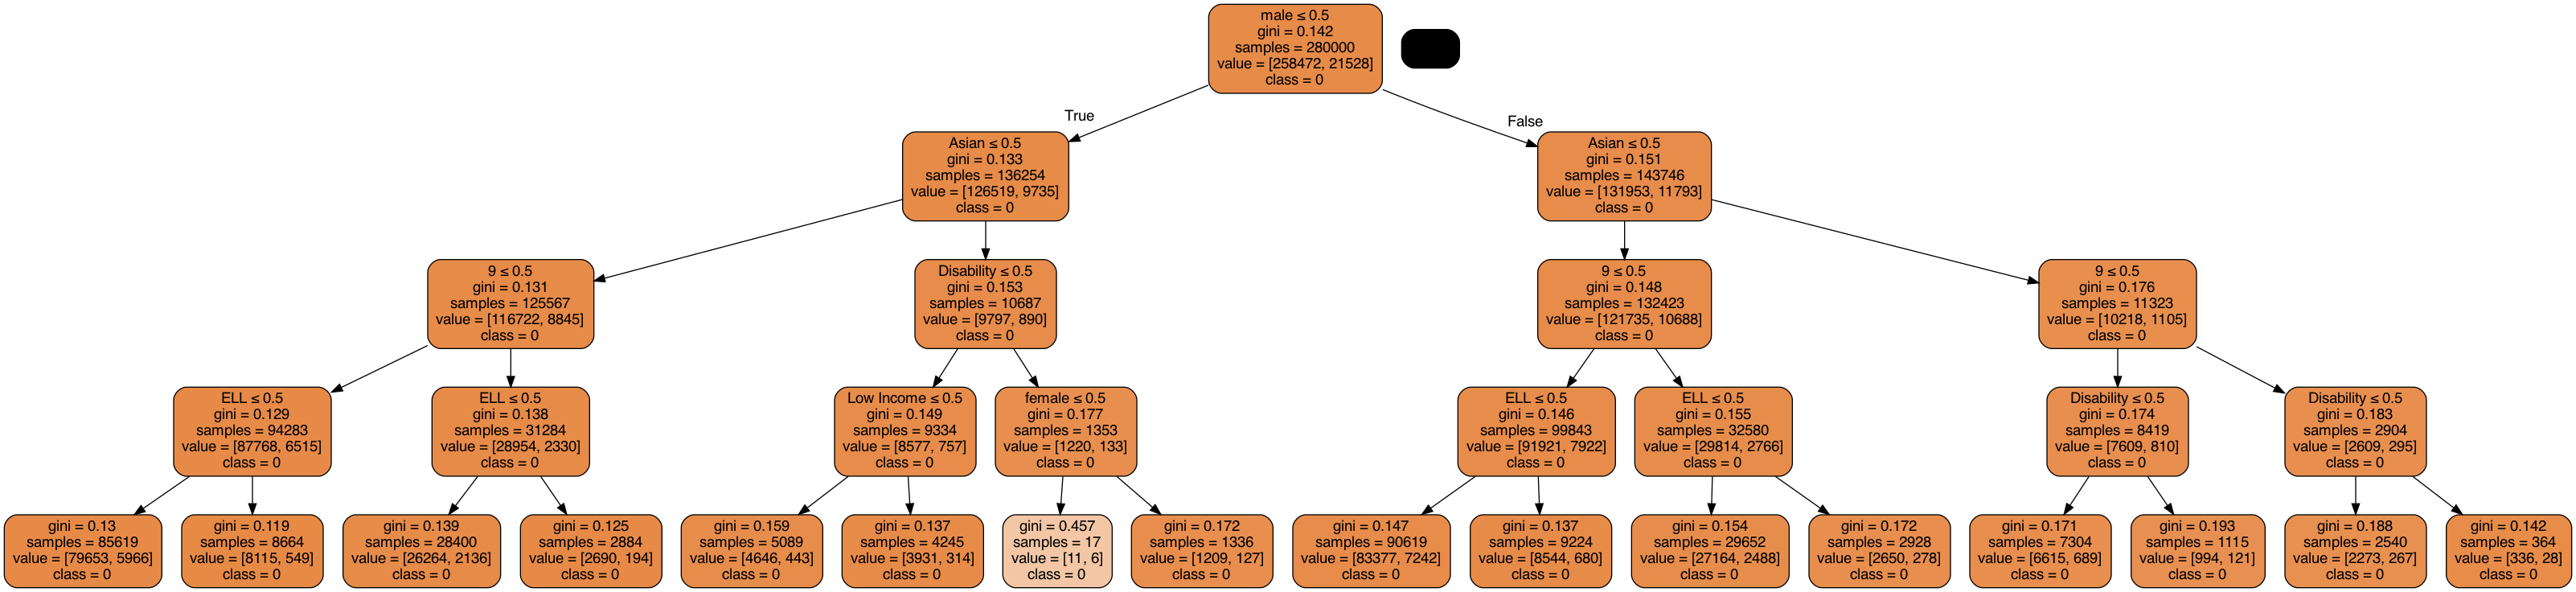

In [74]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = student_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('WA_CS_Students_M3.png')
Image(graph.create_png())

There are two issues with the above image: it is difficult to pick out key indicators and there is a possibility of overfitting. However, if the max_depth or min_samples_split are any less then there are zero students classified as "1" for CS enrollment. We will try a tree with less depth but know that there will only be students classified as "0" in our results. Is there still a way to make this meaningful? Maybe we instead have indicators for not enrolling in CS?

In [75]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9224166666666667


This appears to be a good score, but a confusion matrix will reveal a lot more information about the success of the decision tree classifier.

Confusion matrix

 [[110690      0]
 [  9310      0]]


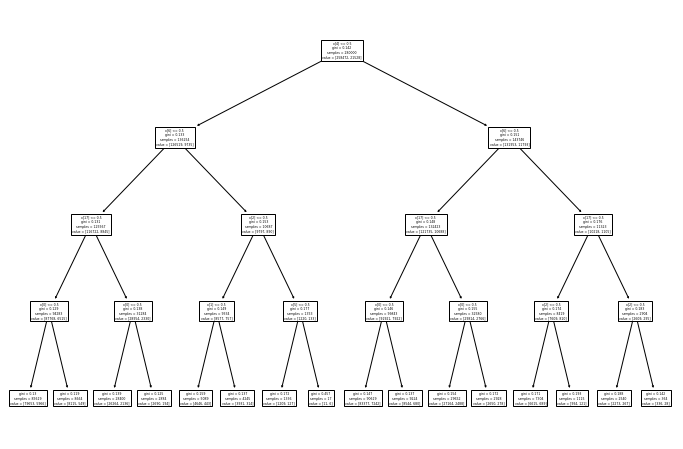

In [76]:

plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(x_train, y_train))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

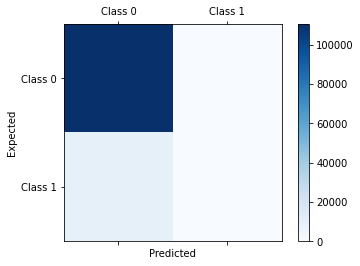

In [77]:


labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Here we can see that the accuracy is actually not great. There are not any false positives and plenty of true positives, but there are quite a few false negatives and zero true negatives. To further help describe what this means in this context:

* true positive: algorithm predicted Class 0 and we expected Class 0
* true negative: algorithm predicted Class 1 and we expected Class 1
* false positive: algorithm predicted Class 1 and we expected Class 0
* false negative: algorithm predicted Class 0 and we expected Class 1

### Imbalanced Classes

Furthermore, it appears that the issue here is that the dataset's classes are imbalanced. If you consider the accuracy score of ~92% and recall that a 7.65% of students were enrolled in CS this imbalance begins to make sense. This has fallen to the [Accuracy Paradox](https://towardsdatascience.com/accuracy-paradox-897a69e2dd9b). What happens is that the algorithm, understandably, decides to just predict one class and voila--high accuracy is acheived because one class is present over 90% of the time! 

To work around this issue we will balance the classes using undersampling methods (undersampling is recommended when a dataset has hundreds of thousands of records versus oversampling which is better for problems with less data). We will undersample with the more simple sample package and then with the imbalanced-learn module.  Then we will test a few different class ratios.

### Undersampling

First, let's look at the current ratio of our dataset's classes.

Class 0: 369162
Class 1: 30838
Proportion: 11.97 : 1


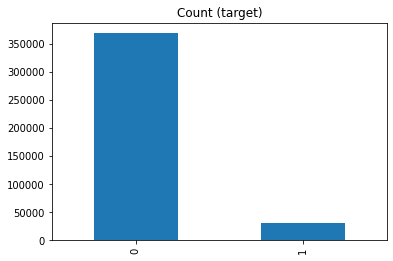

In [78]:
undersample_bisynth = binary_synth.copy(deep=False)


target_count = undersample_bisynth.CS_M3.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [79]:
undersample_bisynth.head()

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,NA,Native,TwoOrMore,White,10,11,12,9,CS_M3
0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


Undersampling using the pandas library's sample().

Random under-sampling:
0    30838
1    30838
Name: CS_M3, dtype: int64


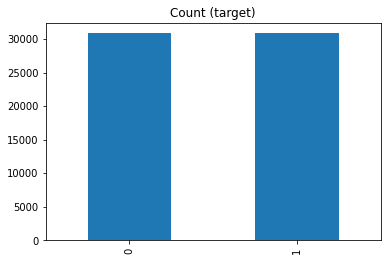

In [80]:
count_class_0, count_class_1 = undersample_bisynth.CS_M3.value_counts()

df_class_0 = undersample_bisynth[undersample_bisynth['CS_M3'] == 0]
df_class_1 = undersample_bisynth[undersample_bisynth['CS_M3'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.CS_M3.value_counts())

df_test_under.CS_M3.value_counts().plot(kind='bar', title='Count (target)');

In [81]:
df_test_under.head()

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,NA,Native,TwoOrMore,White,10,11,12,9,CS_M3
357251,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2334,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
293833,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
169240,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
398472,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


Now, let's try the decision tree again.

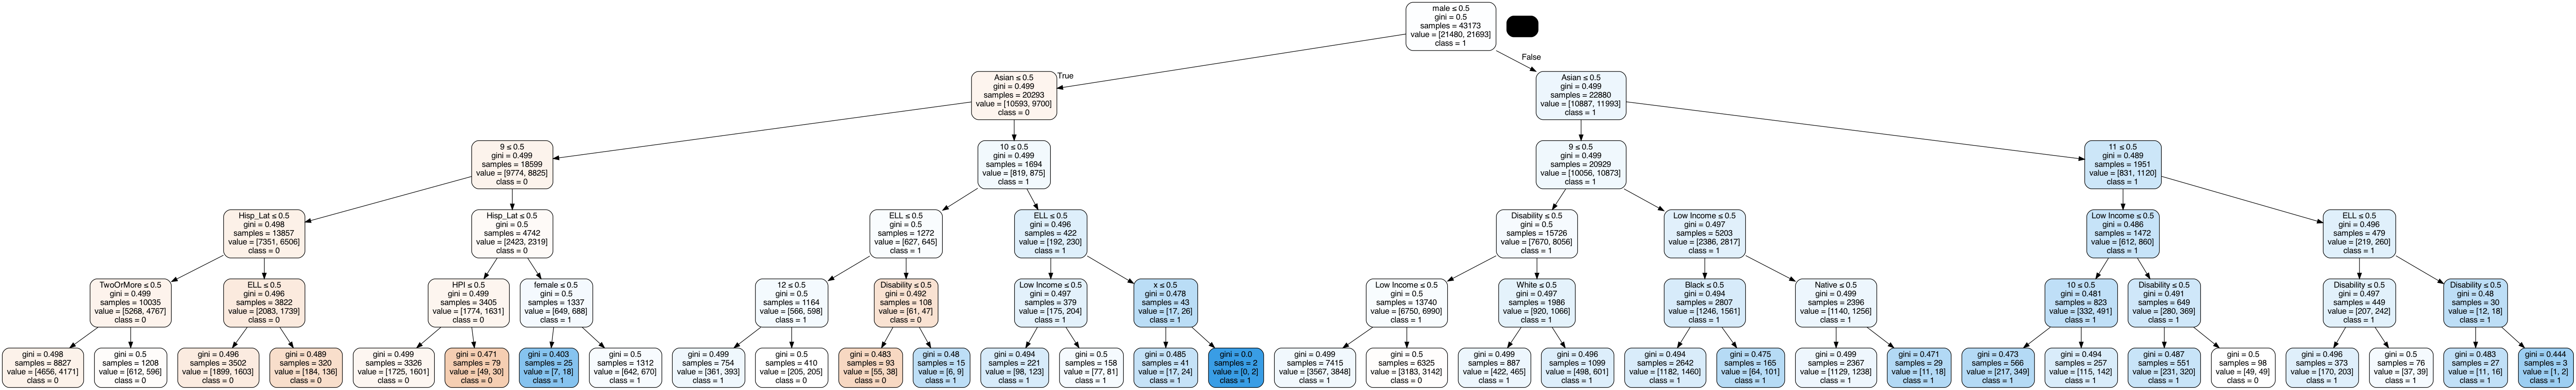

In [82]:
x = df_test_under[student_features]
y = df_test_under.CS_M3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier(max_depth = 5, min_samples_split = 20)
clf = clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = student_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('WA_CS_Students_under.png')
Image(graph.create_png())

This already looks more promising than the last tree.

In [83]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5203480516672971


Confusion matrix

 [[5446 3912]
 [4963 4182]]


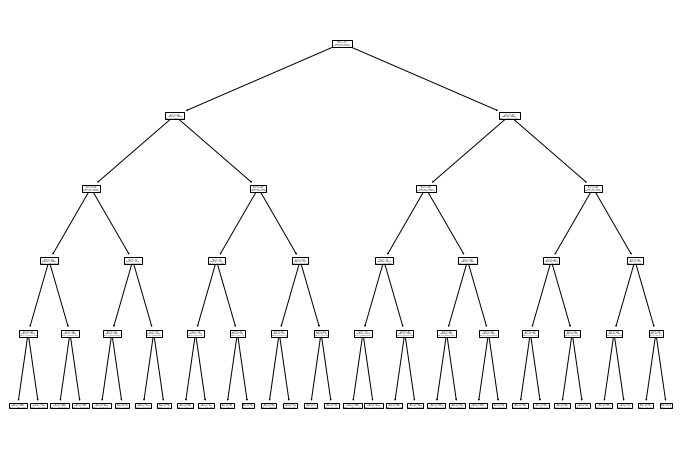

In [84]:
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(x_train, y_train))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

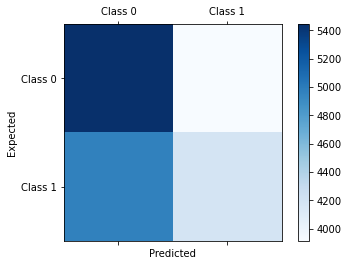

In [85]:
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

We are hoping for better accuracy than this. One possible way to refine this model is revisiting our undersampling strategy and considering the use of a more advanced module--imbalanced-learn. We can also look back to the data we generated--would generating by school lead to better results?

### Random Forest

### Correlation Heatmap

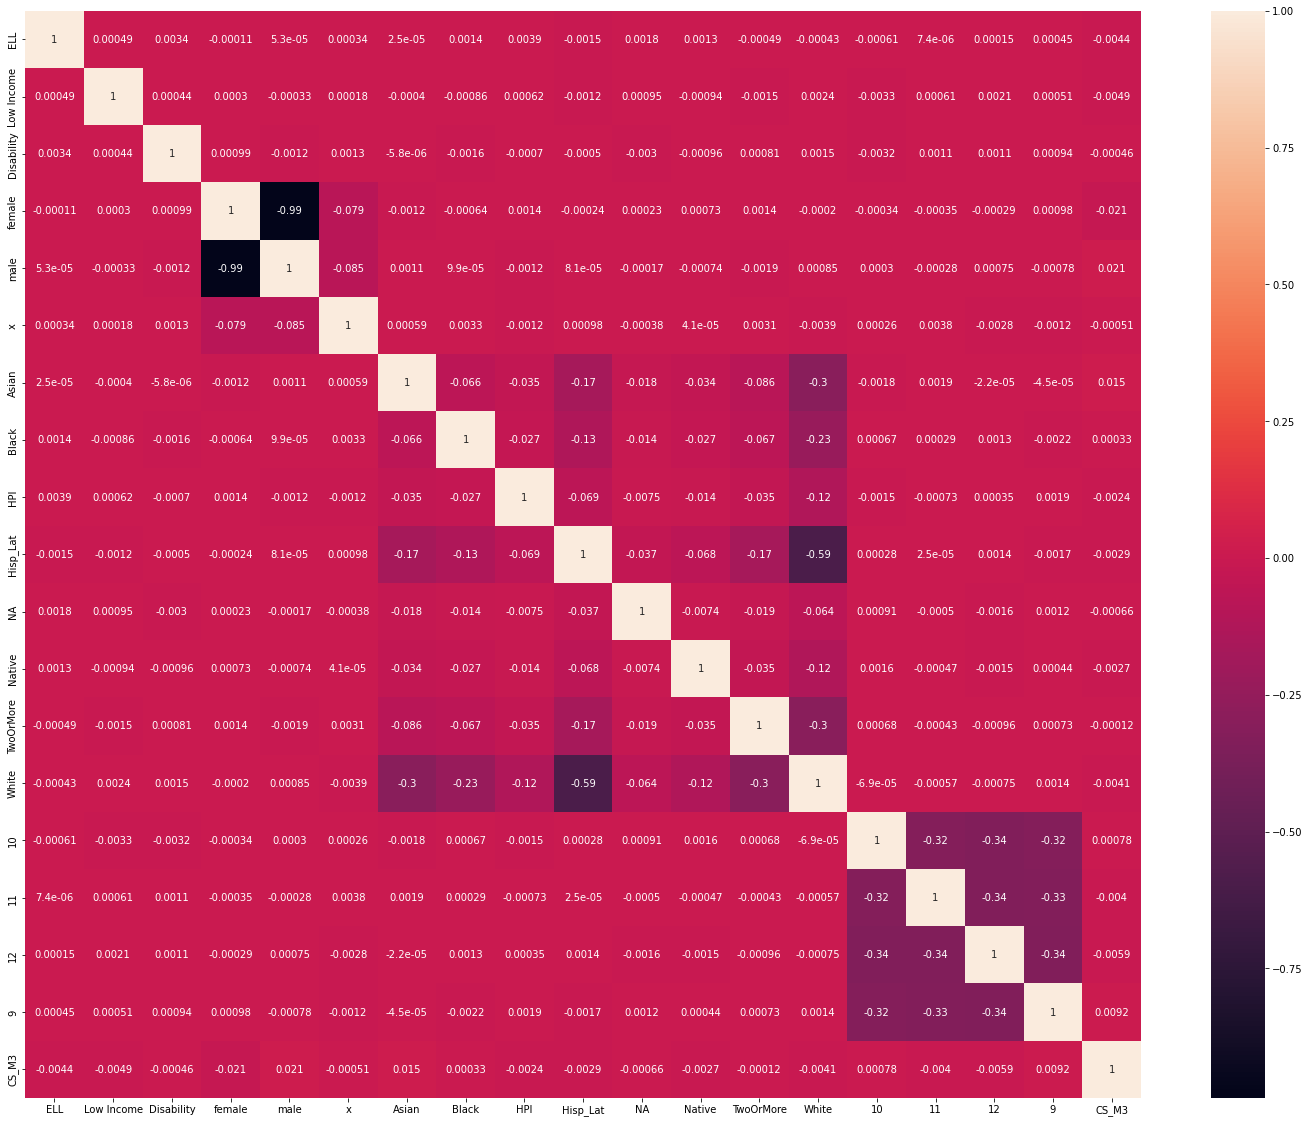

In [86]:
fig = plt.figure(figsize=(25, 20))
sns.heatmap(binary_synth.corr(), annot=True)
plt.savefig("Heatmap.png")

### Logistic Regression

In [87]:
bi_synth_features = binary_synth.copy(deep=False)
bi_synth_features = bi_synth_features.drop('CS_M3', axis=1)

X = bi_synth_features
y = pd.Series(binary_synth.CS_M3)

# Make train and test sets
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    shuffle=True, random_state=2)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(max_iter=2500)

# Train the model
clf_lr.fit(X_train, y_train)

# Make predictions
y_pred = clf_lr.predict(X_test) # Predictions
y_true = y_test # True values

features = list(X_train.columns)
coefficients = clf_lr.coef_[0]

for feature, coefficient in zip(features, coefficients):
    print(f"{feature}: {coefficient}")


ELL: -0.06118756593451542
Low Income: -0.028691196575136642
Disability: -0.005925851667381676
female: -0.06749851374779252
male: 0.08810846821923868
x: 0.0015932205705429052
Asian: 0.1850927854274621
Black: 0.029305026917780384
HPI: -0.08835028454834544
Hisp_Lat: -0.007957905109380489
NA: 0.02184615018850321
Native: -0.15631295191931519
TwoOrMore: 0.03622310764159492
White: 0.002357246452466141
10: 0.004739354432710137
11: -0.024268957047079685
12: -0.0232355286120318
9: 0.06496830629322464


Eigenvalues:
[1.98653412e+00 1.63539049e+00 1.34761461e+00 1.33008472e+00
 1.32258079e+00 1.18169965e+00 1.08601740e+00 1.05930823e+00
 1.02070176e+00 1.01435539e+00 1.01276167e+00 1.00575362e+00
 1.00258227e+00 9.99544584e-01 9.95115699e-01 7.31451721e-25
 1.21760542e-25 2.09716032e-27]

Variances (Percentage):
[1.10362731e+01 9.08548000e+00 7.48672909e+00 7.38934108e+00
 7.34765268e+00 6.56498164e+00 6.03341489e+00 5.88503101e+00
 5.67055118e+00 5.63529366e+00 5.62643965e+00 5.58750616e+00
 5.56988756e+00 5.55301158e+00 5.52840673e+00 4.06361051e-24
 6.76445764e-25 1.16508615e-26]



Text(0, 0.5, 'Explained variance (%)')

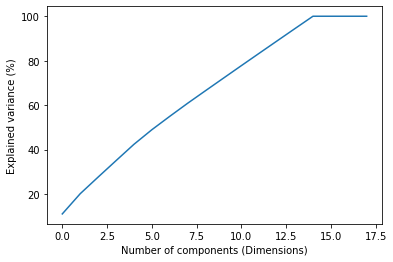

In [88]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

Train accuracy: 0.92
Test accuracy: 0.92

Test confusion_matrix


Text(33.0, 0.5, 'True')

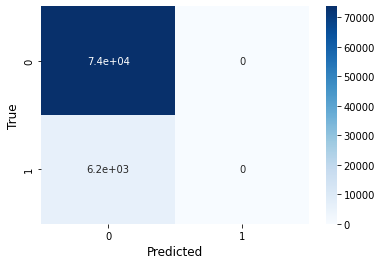

In [89]:
# # Measure accuracy
from sklearn.metrics import accuracy_score
# import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, 
                                                 clf_lr.predict(X_train)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# # Make the confusion matrix
# from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

Unfortunately this model has also fallen to the accuracy paradox. So we can also re-do the analysis with our undersampled dataset.

In [90]:
X = df_test_under[student_features]
y = df_test_under.CS_M3

# Make train and test sets
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    shuffle=True, random_state=2)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(max_iter=2500)

# Train the model
clf_lr.fit(X_train, y_train)

# Make predictions
y_pred = clf_lr.predict(X_test) # Predictions
y_true = y_test # True values

features = list(X_train.columns)
coefficients = clf_lr.coef_[0]

for feature, coefficient in zip(features, coefficients):
    print(f"{feature}: {coefficient}")

ELL: -0.05739630380573027
Low Income: -0.06066205488921026
Disability: 0.025318658863556335
female: -0.08371125666313729
male: 0.08969384884772963
x: 0.002959178471270899
Asian: 0.19634039077298326
Black: -0.041452795336096054
HPI: -0.09640527270261992
Hisp_Lat: -0.011156767523035967
NA: -0.03310106771288306
Native: -0.04744644190174304
TwoOrMore: 0.0370399416963563
White: 0.005123783362900806
10: -0.0005637501418367754
11: -0.026484136956942902
12: -0.042207109848263695
9: 0.07819676760288768


Train accuracy: 0.52
Test accuracy: 0.52

Test confusion_matrix


Text(33.0, 0.5, 'True')

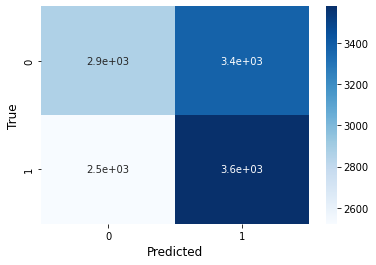

In [91]:
# # Measure accuracy
from sklearn.metrics import accuracy_score
# import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, 
                                                 clf_lr.predict(X_train)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# # Make the confusion matrix
# from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

## Synthetic students created with consideration to school


### Random Forest

In [92]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [93]:
school_students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333357 entries, 0 to 333356
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ['Asian']      333357 non-null  uint8 
 1   ['Black']      333357 non-null  uint8 
 2   ['HPI']        333357 non-null  uint8 
 3   ['Hisp_Lat']   333357 non-null  uint8 
 4   ['NA']         333357 non-null  uint8 
 5   ['Native']     333357 non-null  uint8 
 6   ['TwoOrMore']  333357 non-null  uint8 
 7   ['White']      333357 non-null  uint8 
 8   male           333357 non-null  object
 9   ell            333357 non-null  object
 10  low_income     333357 non-null  object
 11  disability     333357 non-null  object
 12  CS             333357 non-null  int64 
dtypes: int64(1), object(4), uint8(8)
memory usage: 15.3+ MB


In [94]:
school_students['ell'] = school_students['ell'].astype('uint8')
school_students['low_income'] = school_students['low_income'].astype('uint8')
school_students['disability'] = school_students['disability'].astype('uint8')
school_students['male'] = school_students['male'].astype('uint8')
school_students['CS'] = school_students['CS'].astype('uint8')

In [95]:
X = school_students.drop('CS', axis = 1)
y = school_students['CS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [96]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [97]:
y_pred = rf.predict(X_test)

In [98]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9049976001919846


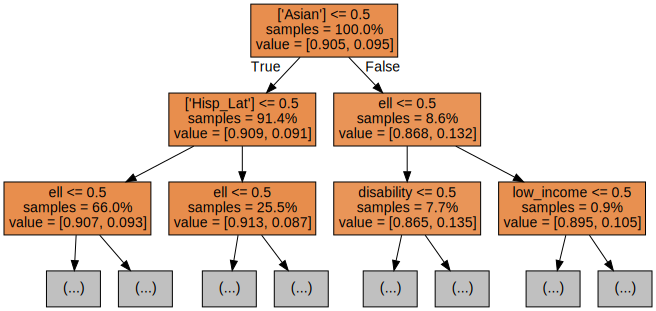

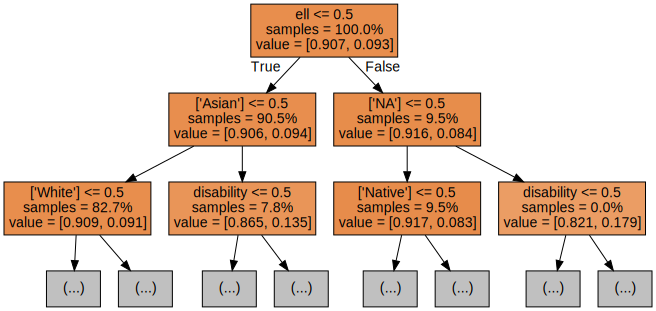

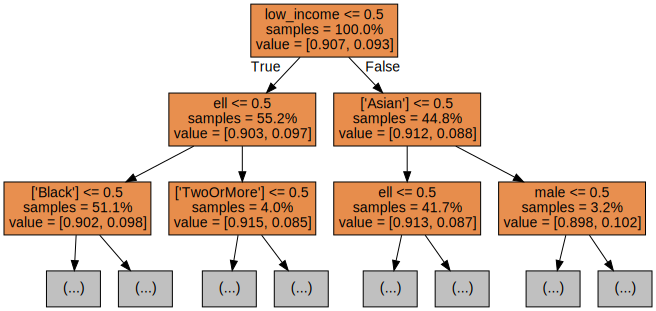

In [99]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [100]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fed219ade20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fed20d512b0>})

In [101]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 11, 'n_estimators': 63}


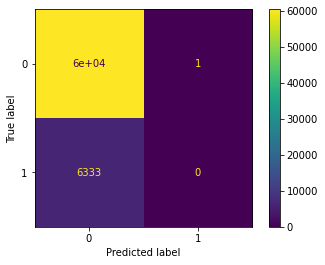

In [102]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [103]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9049976001919846
Precision: 0.0
Recall: 0.0


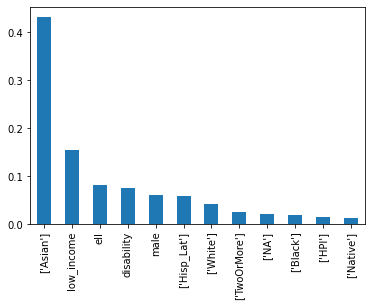

In [104]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

Class 0: 301947
Class 1: 31410
Proportion: 9.61 : 1


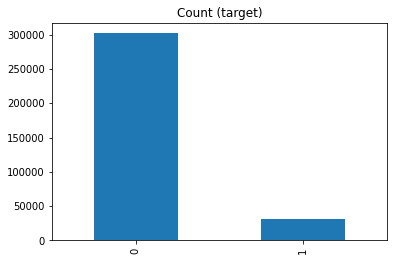

In [105]:
undersample_school = school_students.copy(deep=False)


target_count = undersample_school.CS.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Random under-sampling:
0    31410
1    31410
Name: CS, dtype: int64


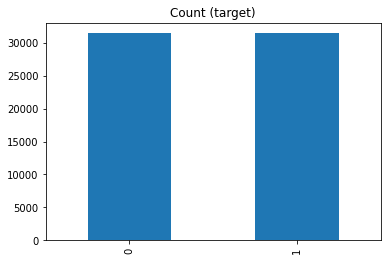

In [106]:
count_class_0, count_class_1 = undersample_school.CS.value_counts()

df_class_0 = undersample_school[undersample_school['CS'] == 0]
df_class_1 = undersample_school[undersample_school['CS'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.CS.value_counts())

df_test_under.CS.value_counts().plot(kind='bar', title='Count (target)');

In [107]:
X = school_students.drop('CS', axis = 1)
y = school_students['CS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [108]:
X = df_test_under.drop('CS', axis = 1)
y = df_test_under['CS']

In [109]:
X_train, Xu_test, y_train, yu_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [110]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [111]:
y_pred = rf.predict(X_test)

In [112]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6091012718982481


In [113]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fece2b64670>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fece2b80bb0>})

In [114]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 6, 'n_estimators': 53}


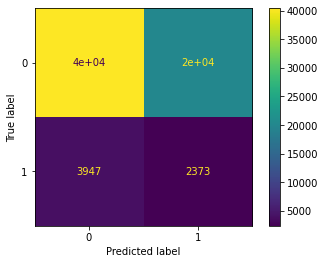

In [115]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [116]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6412287017038637
Precision: 0.10619350219278618
Recall: 0.3754746835443038


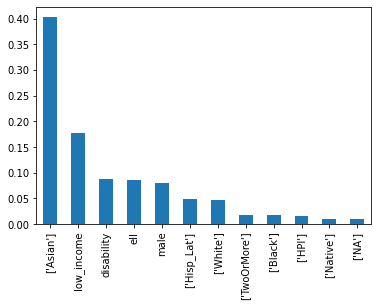

In [117]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

### Correlation Heatmap

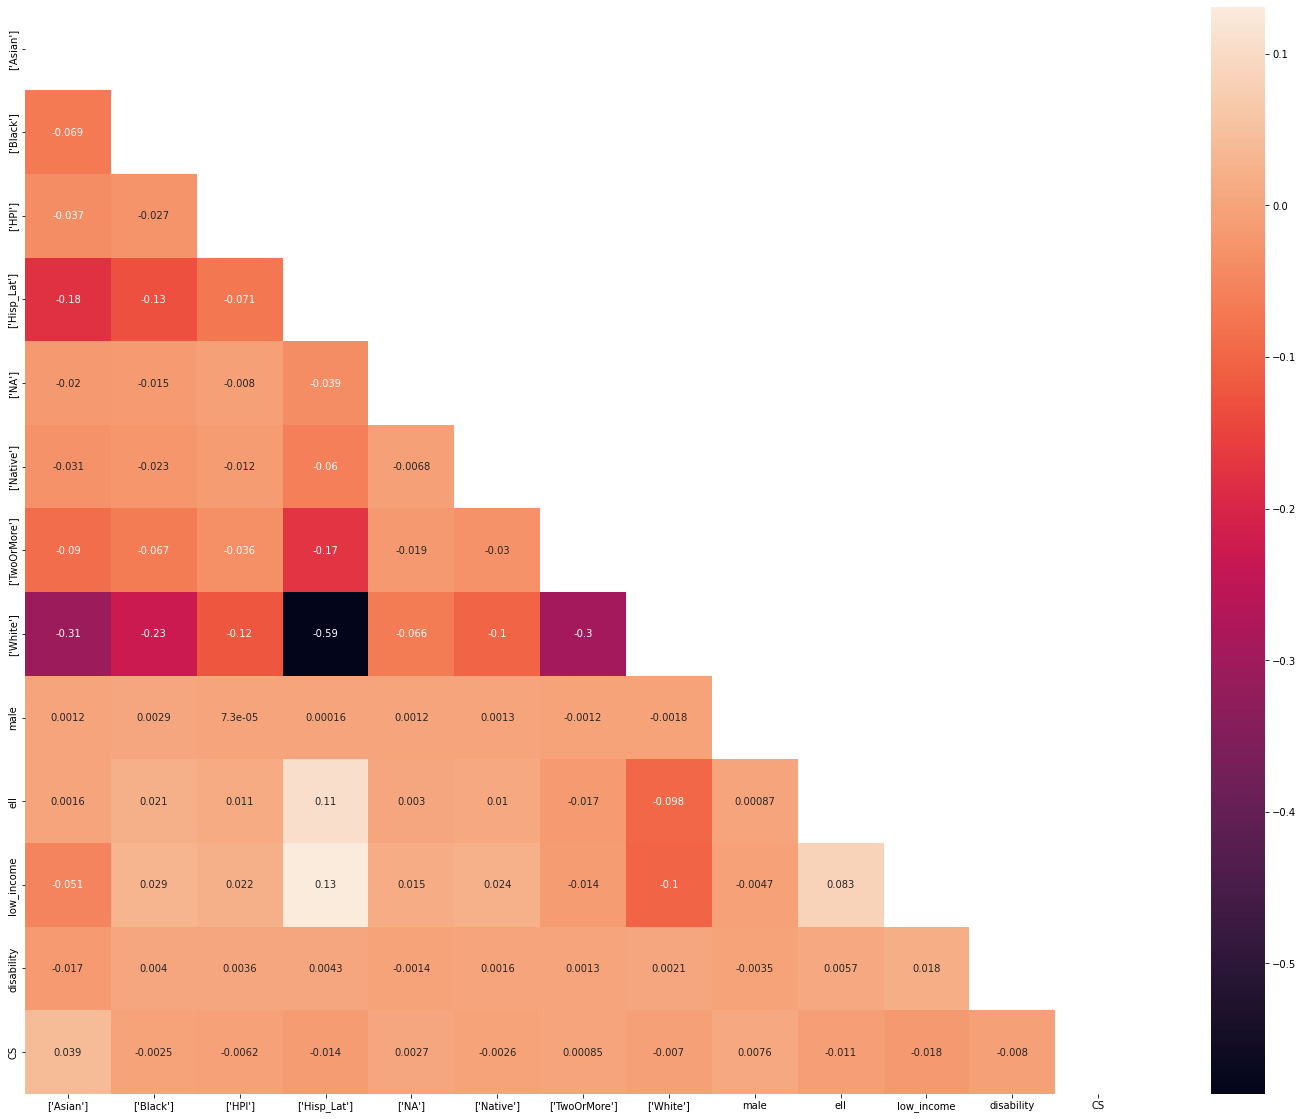

In [118]:
fig = plt.figure(figsize=(25, 20))
corr = school_students.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask)
plt.savefig("Heatmap.png")

## Further Feature Engineering

Feature engineering may be helpful to improve our model. One way to interpret the importance of our features for feature engineering is inspecting the mutual information between our demographic features and our target, CS enrollment.

### Mutual Information

This will tell us more about which features have the most effect on our dependent variable, CS enrollment.

In [119]:
X = school_students.drop('CS', axis = 1)
y = school_students['CS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [120]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.0012953 , 0.00206521, 0.        , 0.00953587, 0.        ,
       0.        , 0.00138039, 0.03743023, 0.03762828, 0.0011866 ,
       0.03049685, 0.00253625])

In [121]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

male             0.037628
['White']        0.037430
low_income       0.030497
['Hisp_Lat']     0.009536
disability       0.002536
['Black']        0.002065
['TwoOrMore']    0.001380
['Asian']        0.001295
ell              0.001187
['HPI']          0.000000
['NA']           0.000000
['Native']       0.000000
dtype: float64

<AxesSubplot:>

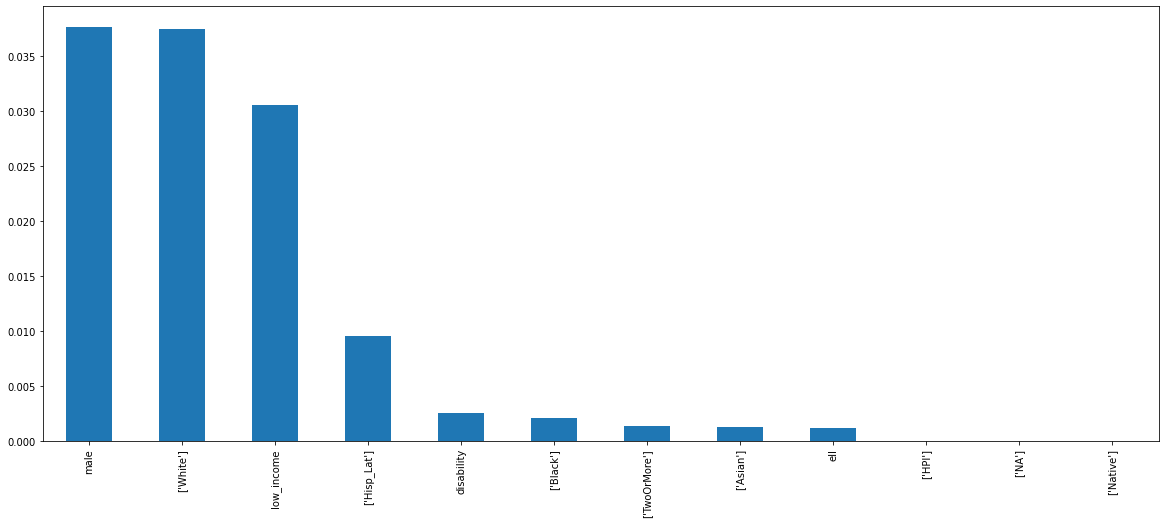

In [122]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

From here you can see that NA, HPI and Native have the least importance as features. Conversely you can visually see the importance of gender, White, and low income as features. One possibility for improving our model would be to only use these features. However, the point of this analysis is to find the most influential features, the key predictors, so it is possible that this is already helping us acheive that objective without using this for feature engineering.

Let's compare this to the feature importance bar chart that resulted from our imperfect random forest model:

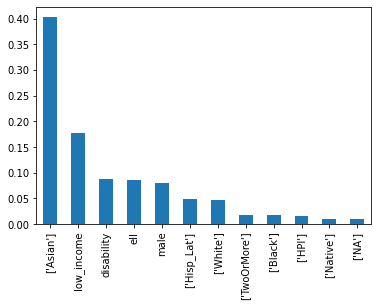

In [123]:
feature_importances.plot.bar();

This is a curious disparity. There are a few different possible reasons for this:
* These are measures of two different things--mutual information measures the dependency between two variables while random forest feature imporance measures the reduction in impurity.
* The feature importance chart is based on an undersampled data set.

Possible next steps:
* Use a more sophisticated balancing strategy with imbalance-learn package.
* Try using the undersampled data set for mutual importance.
* Create models without the weakest features from both charts or try two different models with only the strongest features from each chart.

Regardless, gender and low income appear to be important features in both of these charts.

It is also possible that the lack of importance of some racial features is because they are not represented as well as white and Asian in the available data. Let's check this assumption:

In [124]:
print(f"White: {Prob_R_White}")
print(f"Hisp_Lat: {Prob_R_Hisp_Lat}")
print(f"TwoOrMore: {Prob_R_TwoOrMore}")
print(f"Asian: {Prob_R_Asian}")
print(f"Black: {Prob_R_Black}")
print(f"HPI: {Prob_R_HPI}")
print(f"Native: {Prob_R_Native}")
print(f"NA: {Prob_R_NA}")

White: 0.5076661293670542
Hisp_Lat: 0.2533448822852574
TwoOrMore: 0.07979539904106114
Asian: 0.07834750898845019
Black: 0.04935383101457372
HPI: 0.013902307142326311
Native: 0.013763924730218362
NA: 0.003826017431058651


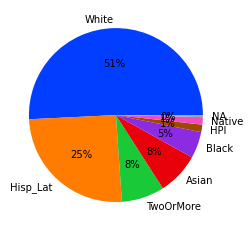

In [125]:
race_probs = [Prob_R_White, Prob_R_Hisp_Lat, Prob_R_TwoOrMore, Prob_R_Asian, Prob_R_Black, Prob_R_HPI, Prob_R_Native, Prob_R_NA]
lables = ['White', 'Hisp_Lat', 'TwoOrMore', 'Asian', 'Black', 'HPI', 'Native', 'NA']
palette_color = sns.color_palette('bright') 
plt.pie(race_probs, labels=lables, colors=palette_color, autopct='%.0f%%')  
plt.show() 

Some of the least important features may be due to this explanation. However, Asian is a smaller proportion of the students than expected. So let's look at the percent enrolled in CS for each racial group.

In [126]:
print(f"White: {Prob_RC_White}")
print(f"Hisp_Lat: {Prob_RC_Hisp_Lat}")
print(f"TwoOrMore: {Prob_RC_TwoOrMore}")
print(f"Asian: {Prob_RC_Asian}")
print(f"Black: {Prob_RC_Black}")
print(f"HPI: {Prob_RC_HPI}")
print(f"Native: {Prob_RC_Native}")
print(f"NA: {Prob_RC_NA}")

White: 0.07235629950076475
Hisp_Lat: 0.06624452514136009
TwoOrMore: 0.07534202582054082
Asian: 0.15484250809537828
Black: 0.06360662547380445
HPI: 0.057327188940092165
Native: 0.04952522807670825
NA: 0.06965840589417281


So it appears that this high percentage, compared to other racial groups (more than double the second highest enrolled racial group, white), is what is making this feature more important in the random forest analysis.